In [35]:
import snowflake.connector
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user='',
    password='',
    account='',
    warehouse='COMPUTE_WH',
    database='SPOTIFYPLAYLIST_DW',
    schema='SPOTIFYPLAYLIST_DW_SCHEMA',
    role='ACCOUNTADMIN'
)

# Query the data
query = """
    SELECT 
        s.song_id,
        s.song_name,
        s.duration_ms,
        s.popularity,
        s.song_added,
        a.name AS album_name,
        a.release_date,
        a.total_tracks,
        ar.artist_name
    FROM 
        song s
    JOIN 
        album a ON s.album_id = a.album_id
    JOIN 
        artist ar ON s.artist_id = ar.artist_id;
"""
df = pd.read_sql(query, conn)

C:\Users\spava\AppData\Local\Temp\ipykernel_44096\1548356228.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [37]:
# Display the first few rows
df.head()

,SONG_ID,SONG_NAME,DURATION_MS,POPULARITY,SONG_ADDED,ALBUM_NAME,RELEASE_DATE,TOTAL_TRACKS,ARTIST_NAME
0,1d7Ptw3qYcfpdLNL5REhtJ,Taste,157279,81,2024-08-23,Short n' Sweet,2024-08-23,12,Sabrina Carpenter
1,1d7Ptw3qYcfpdLNL5REhtJ,Taste,157279,81,2024-08-23,Short n' Sweet,2024-08-23,12,Sabrina Carpenter
2,1d7Ptw3qYcfpdLNL5REhtJ,Taste,157279,81,2024-08-23,Short n' Sweet,2024-08-23,12,Sabrina Carpenter
3,1d7Ptw3qYcfpdLNL5REhtJ,Taste,157279,81,2024-08-23,Short n' Sweet,2024-08-23,12,Sabrina Carpenter
4,1d7Ptw3qYcfpdLNL5REhtJ,Taste,157279,81,2024-08-23,Short n' Sweet,2024-08-23,12,Sabrina Carpenter


In [38]:
# Remove Duplicates
df = df.drop_duplicates()

# Handle Missing Values
print(df.isnull().sum())
df = df.fillna(0)  # Replace missing values with 0

SONG_ID         0
SONG_NAME       0
DURATION_MS     0
POPULARITY      0
SONG_ADDED      0
ALBUM_NAME      0
RELEASE_DATE    0
TOTAL_TRACKS    0
ARTIST_NAME     0
dtype: int64


In [39]:
# Feature Engineering
df['song_added_year'] = pd.to_datetime(df['SONG_ADDED']).dt.year
df['release_year'] = pd.to_datetime(df['RELEASE_DATE']).dt.year
df['release_month'] = pd.to_datetime(df['RELEASE_DATE']).dt.month

# Convert Song Duration from Milli Seconds to Minutes
df['duration_minutes'] = df['DURATION_MS'] / 60000

In [40]:
# Display the first few rows
df.head()

,SONG_ID,SONG_NAME,DURATION_MS,POPULARITY,SONG_ADDED,ALBUM_NAME,RELEASE_DATE,TOTAL_TRACKS,ARTIST_NAME,song_added_year,release_year,release_month,duration_minutes
0,1d7Ptw3qYcfpdLNL5REhtJ,Taste,157279,81,2024-08-23,Short n' Sweet,2024-08-23,12,Sabrina Carpenter,2024,2024,8,2.621317
900,2plbrEY59IikOBgBGLjaoe,Die With A Smile,251667,100,2024-08-16,Die With A Smile,2024-08-16,1,Lady Gaga,2024,2024,8,4.194450
1800,7ne4VBA60CxGM75vw0EYad,That’s So True,166300,93,2024-11-01,The Secret of Us (Deluxe),2024-10-18,20,Gracie Abrams,2024,2024,10,2.771667
2700,5vNRhkKd0yEAg8suGBpjeY,APT.,169917,98,2024-10-18,APT.,2024-10-18,1,ROSÉ,2024,2024,10,2.831950
3600,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,210373,97,2024-05-31,HIT ME HARD AND SOFT,2024-05-17,10,Billie Eilish,2024,2024,5,3.506217


In [41]:
# Normalize Features
scaler = MinMaxScaler()
df[['DURATION_MS', 'TOTAL_TRACKS', 'duration_minutes']] = scaler.fit_transform(
    df[['DURATION_MS', 'TOTAL_TRACKS', 'duration_minutes']]
)

In [42]:
# Display the first few rows
df.head()

,SONG_ID,SONG_NAME,DURATION_MS,POPULARITY,SONG_ADDED,ALBUM_NAME,RELEASE_DATE,TOTAL_TRACKS,ARTIST_NAME,song_added_year,release_year,release_month,duration_minutes
0,1d7Ptw3qYcfpdLNL5REhtJ,Taste,0.313127,81,2024-08-23,Short n' Sweet,2024-08-23,0.333333,Sabrina Carpenter,2024,2024,8,0.313127
900,2plbrEY59IikOBgBGLjaoe,Die With A Smile,0.733569,100,2024-08-16,Die With A Smile,2024-08-16,0.000000,Lady Gaga,2024,2024,8,0.733569
1800,7ne4VBA60CxGM75vw0EYad,That’s So True,0.353310,93,2024-11-01,The Secret of Us (Deluxe),2024-10-18,0.575758,Gracie Abrams,2024,2024,10,0.353310
2700,5vNRhkKd0yEAg8suGBpjeY,APT.,0.369421,98,2024-10-18,APT.,2024-10-18,0.000000,ROSÉ,2024,2024,10,0.369421
3600,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,0.549629,97,2024-05-31,HIT ME HARD AND SOFT,2024-05-17,0.272727,Billie Eilish,2024,2024,5,0.549629


In [43]:
# Encode Categorical Variables
df = pd.get_dummies(df, columns=['ALBUM_NAME', 'ARTIST_NAME'], drop_first=True)

In [44]:
# Drop Redundant Columns
X = df.drop(columns=['POPULARITY', 'SONG_ID', 'SONG_NAME', 'SONG_ADDED', 'RELEASE_DATE'])
y = df['POPULARITY']

In [45]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Display first few rows of X_train
print("X_train:")
print(X_train.head(), "\n")

# Display first few rows of X_test
print("X_test:")
print(X_test.head(), "\n")

# Display first few rows of y_train
print("y_train:")
print(y_train.head(), "\n")

# Display first few rows of y_test
print("y_test:")
print(y_test.head(), "\n")

X_train:
         DURATION_MS  TOTAL_TRACKS  song_added_year  release_year  \
318563      0.288449      0.424242             2024          2024   
1779923     0.316303      0.333333             2024          2024   
280763      0.671813      0.000000             2024          2024   
67500       0.545682      0.090909             2024          2024   
75600       0.313127      0.333333             2024          2024   

         release_month  duration_minutes  ALBUM_NAME_2 hands  \
318563               6          0.288449               False   
1779923             11          0.316303               False   
280763               6          0.671813               False   
67500                2          0.545682               False   
75600                8          0.313127               False   

         ALBUM_NAME_A Bar Song (Tipsy)  ALBUM_NAME_A Minute...  \
318563                           False                   False   
1779923                          False                   Fa

In [47]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 105.33663059583945
R2 Score: 0.3790677431343473


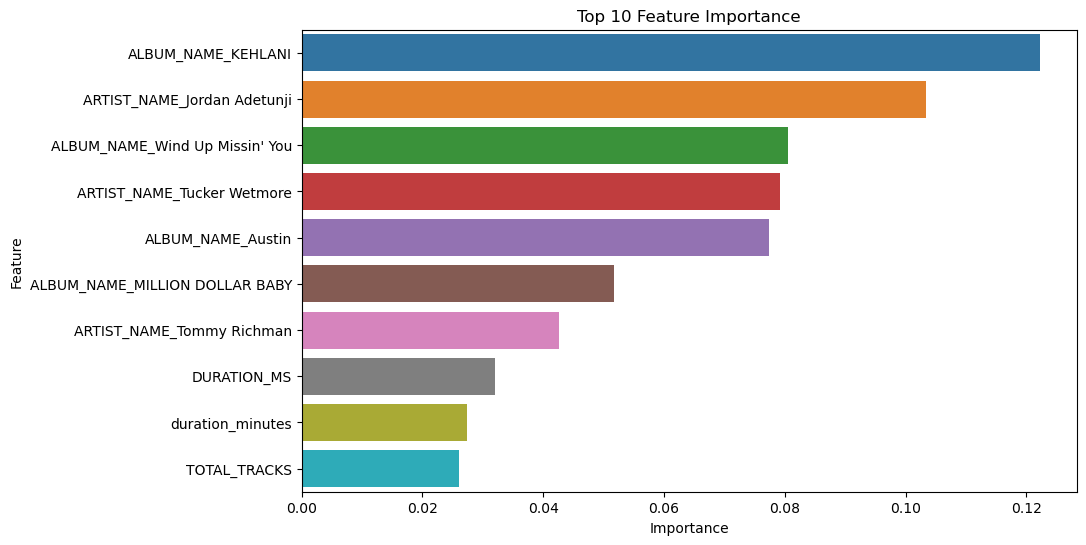

In [49]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Sort and select top 10 features
top_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title('Top 10 Feature Importance')
plt.show()

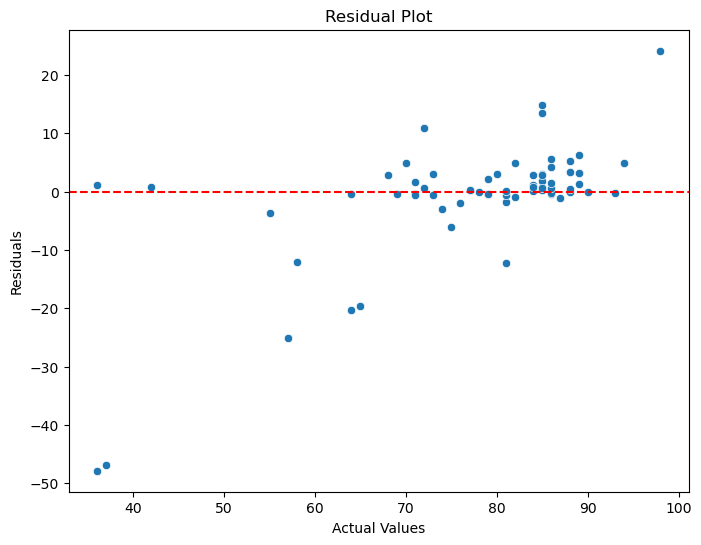

In [51]:
# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

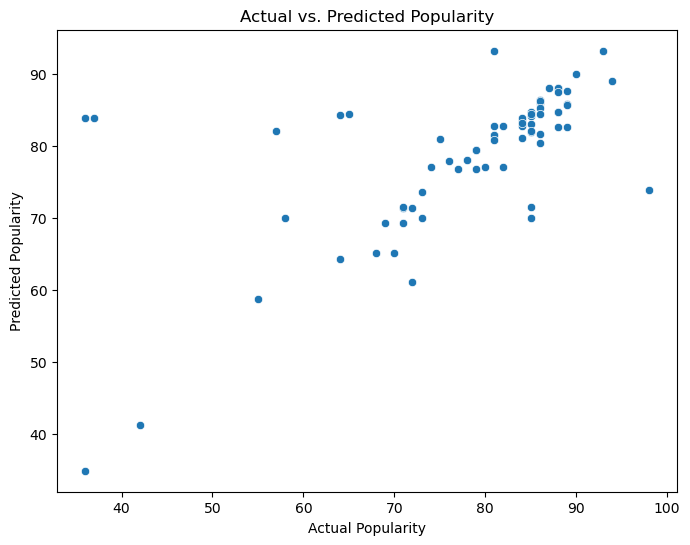

In [53]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Actual vs. Predicted Popularity")
plt.show()